In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
from pytz import timezone
import MySQLdb
import time
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import Queue
est = timezone('US/Eastern')

Using TensorFlow backend.


In [ ]:
btc = pd.read_csv('live_bitcoin')
twitter_sent = pd.read_csv('live_tweet.csv')
reddit_sent = pd.read_csv('live_reddit.csv')

btc.columns = ["price_usd","24h_volume_usd","market_cap_usd","available_supply","total_supply","percent_change_1h","percent_change_24h","percent_change_7d", "Sell", "Buy", "15m", "Stamp"]
twitter_sent.columns = ["Sentiment", "Stamp"]
reddit_sent.columns = ["Sentiment", "Stamp"]

merged = pd.merge(twitter_sent, btc,  on='Stamp', how='inner').merge(reddit_sent, on='Stamp', how='inner')
data = merged[["Sentiment_x", "Sentiment_y","24h_volume_usd", "market_cap_usd", "available_supply","price_usd"]].groupby(merged['Stamp']).mean()
datag = data[["24h_volume_usd", "market_cap_usd", "available_supply","price_usd"]]
tw_sentiment = data["Sentiment_x"]
rdt_sentiment = data["Sentiment_y"]

print "Dataset size: " + str(len(datag))
print "Timespan: " + str(len(datag)/60) + " hours"

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
values = datag.values.reshape(-1, datag.shape[1])
tw_sentiment = tw_sentiment.values.reshape(-1, 1)
rdt_sentiment = rdt_sentiment.values.reshape(-1, 1)
tw_sentiment = tw_sentiment.astype('float32')
rdt_sentiment = rdt_sentiment.astype('float32')
values = values.astype('float32')
scaled = scaler.fit_transform(values)

In [3]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
split = train_size

def create_dataset(dataset, look_back, tw_sentiment, rdt_sentiment, sent=False):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        if i >= look_back:
            a = dataset[i-look_back:i+1, 0]
            a = a.tolist()
            if(sent==True):                
                current_tw_sentiment = tw_sentiment[i].tolist()[0]
                current_rdt_sentiment = rdt_sentiment[i].tolist()[0]
                a.append(current_tw_sentiment)
                a.append(current_rdt_sentiment)
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

look_back = 2
trainX, trainY = create_dataset(train, look_back, tw_sentiment[0:train_size], rdt_sentiment[0:train_size], sent=True)
testX, testY = create_dataset(test, look_back, tw_sentiment[train_size:len(scaled)], rdt_sentiment[train_size:len(scaled)], sent=True)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Creating new model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.save('models/LSTM_14-03-2018.h5')

# Loading model
# model = load_model('models/LSTM_12-03-2018_GOOD.h5')

history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)
yhat = model.predict(testX)
# yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
# testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
# rmse_sent = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print "Done"
# print 'Test RMSE: %.3f' % rmse_sent

710
302
Done


In [4]:
#Enter the values for you database connection
dsn_database = "ai_datasets"         # e.g. "MySQLdbtest"
dsn_hostname = "127.0.0.1"      # e.g.: "mydbinstance.xyz.us-east-1.rds.amazonaws.com"
dsn_port = 3306                  # e.g. 3306 
dsn_uid = "root"             # e.g. "user1"
dsn_pwd = ""              # e.g. "Password123"

conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)
cursor=conn.cursor()


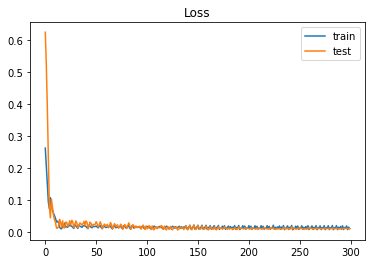

In [4]:
pyplot.title("Loss")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [6]:
true_q = Queue.Queue()
pred_q = Queue.Queue()

prev = 8205
threshold = 0.05

def process_data(in_data):
    out_data = []
    for line in in_data:
        out_data.append(float(line.split(',')[0]))
    return np.array(out_data).reshape(-1,1)

In [ ]:
trades = []
bought = False
status = 0

while True:
    
    btc = open('live_bitcoin','r')
    tw_sent = open('live_tweet.csv','r')
    rdt_sent = open('live_reddit.csv','r')
    
    bit_data = btc.readlines()
    tw_sent_data = tw_sent.readlines()
    rdt_sent_data = rdt_sent.readlines()
    bit_data = process_data(bit_data[len(bit_data)-5:])
    tw_sent_data = process_data(tw_sent_data[len(tw_sent_data)-5:])
    rdt_sent_data = process_data(rdt_sent_data[len(rdt_sent_data)-5:])
    live = scaler.fit_transform(bit_data)
    testX, testY = create_dataset(live, 2, tw_sent_data, rdt_sent_data, sent=True)
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    yhat = model.predict(testX)
    yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
    true_q.put(bit_data[4])
    pred_q.put(yhat_inverse[0])
    val = 100 * ((yhat_inverse[0][0] - prev)/prev)
    print "Diff: " + str(val)
    print "Prev: " + str(prev)
    
    if val > threshold and not bought:
        decision = 2
        print "Buy at: " + str(prev)
        bought = True
        trades.append(("Buy", str(prev)))
    elif val <-threshold and bought:
        decision = 1
        print "Sell at: " + str(prev)
        bought = False
        trades.append(("Sold", str(prev)))
    else:
        decision = 0
        
    prev = yhat_inverse[0][0]
    input_string = "INSERT INTO live_data values ({},{},{},{},'{}',{});".format(
        yhat_inverse[0][0],
        bit_data[0][0],
        tw_sent_data[4][0],
        rdt_sent_data[4][0],
        datetime.now(tz=est).strftime('%Y-%m-%d %H:%M:%S'),
        decision)
    
    #cursor.execute(input_string)
    #conn.commit()
    
    print trades
    for trade in trades:
        if(trade[0] == "Buy"):
            status = status - float(trade[1])
        if(trade[0] == "Sold"):
            status =  status + float(trade[1])
    print "Status:" + str(status)
    status = 0
    time.sleep(60)

1
Diff: -0.811534744439
Prev: 8205
[]
Status:0
1
Diff: 0.293607823551
Prev: 8138.41
Buy at: 8138.41
[('Buy', '8138.41')]
Status:-8138.41
1
Diff: 0.278732134029
Prev: 8162.31
[('Buy', '8138.41')]
Status:-8138.41
1
Diff: 0.245242472738
Prev: 8185.06
[('Buy', '8138.41')]
Status:-8138.41
1
Diff: 0.000868834922585
Prev: 8205.13
[('Buy', '8138.41')]
Status:-8138.41
1
Diff: 0.0
Prev: 8205.2
[('Buy', '8138.41')]
Status:-8138.41
1
Diff: 0.132049864624
Prev: 8205.2
[('Buy', '8138.41')]
Status:-8138.41
1
Diff: 0.125623657368
Prev: 8216.04
[('Buy', '8138.41')]
Status:-8138.41
1
Diff: 0.110650865827
Prev: 8226.36
[('Buy', '8138.41')]
Status:-8138.41
1
Diff: 0.0
Prev: 8235.46
[('Buy', '8138.41')]
Status:-8138.41
1
Diff: 0.000201586271942
Prev: 8235.46
[('Buy', '8138.41')]
Status:-8138.41
1
Diff: 0.0
Prev: 8235.48
[('Buy', '8138.41')]
Status:-8138.41
1
Diff: 0.0350522255758
Prev: 8235.48
[('Buy', '8138.41')]
Status:-8138.41
1
Diff: 0.0333448435413
Prev: 8238.37
[('Buy', '8138.41')]
Status:-8138.41
1


1
Diff: -0.03813643998
Prev: 8286.45
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91')]
Status:-8118.01
1
Diff: -0.0410394277424
Prev: 8283.29
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91')]
Status:-8118.01
1
Diff: -0.0372702779714
Prev: 8279.89
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91')]
Status:-8118.01
1
Diff: 0.0
Prev: 8276.8
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91')]
Status:-8118.01
1
Diff: -0.00659552315483
Prev: 8276.8
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91')]
Status:-8118.01
1
Diff: -0.000153394375957
Prev: 8276.26
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91')]
Status:-8118.01
1
Diff: -0.0817239284515
Prev: 8276.24
Sell at: 8276.24
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24')]
Status:158.23
1
Diff: -0.0878371007275
Prev: 8269.48
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24')]
Status:158.23
1
Diff: -0.079687865218

1
Diff: -1.18891492207e-05
Prev: 8213.9
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64')]
Status:206.66
1
Diff: 0.02822484239
Prev: 8213.9
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64')]
Status:206.66
1
Diff: 0.0268500123639
Prev: 8216.21
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64')]
Status:206.66
1
Diff: 0.0236107356614
Prev: 8218.42
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64')]
Status:206.66
1
Diff: 0.000285115197585
Prev: 8220.36
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64')]
Status:206.66
1
Diff: -2.37595330077e-05
Prev: 8220.38
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.2

1
Diff: -0.0428497471148
Prev: 8291.14
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38')]
Status:-8013.72
1
Diff: 0.0
Prev: 8287.59
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38')]
Status:-8013.72
1
Diff: -0.0018499984435
Prev: 8287.59
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38')]
Status:-8013.72
1
Diff: 0.0
Prev: 8287.44
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38')]
Status:-8013.72
1
Diff: -0.0185474607861
Prev: 8287.44
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38')]
Status:-8013.72
1
Diff: -0.0198591282242
Prev: 

1
Diff: -0.00662477250444
Prev: 8240.26
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05')]
Status:-7958.66
1
Diff: -0.00597335674684
Prev: 8239.71
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05')]
Status:-7958.66
1
Diff: 0.000343725582752
Prev: 8239.22
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05')]
Status:-7958.66
1
Diff: 0.0
Prev: 8239.25
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05')]
Status:-7958.66
1
Diff: 0.0782980467193
Prev: 8239.25
[('Buy', '81

1
Diff: 0.0
Prev: 8257.75
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05'), ('Sold', '8256.64'), ('Buy', '8243.05')]
Status:-7945.07
1
Diff: 0.000236520190811
Prev: 8257.75
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05'), ('Sold', '8256.64'), ('Buy', '8243.05')]
Status:-7945.07
1
Diff: 0.0
Prev: 8257.77
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05'), ('Sold', '8256.64'), ('Buy', '8243.05')]
Status:-7945.07
1
Diff: 0.0412844994571
Prev: 8257.77
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), 

1
Diff: 3.5365610529e-05
Prev: 8284.0
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05'), ('Sold', '8256.64'), ('Buy', '8243.05')]
Status:-7945.07
1
Diff: 0.0
Prev: 8284.0
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05'), ('Sold', '8256.64'), ('Buy', '8243.05')]
Status:-7945.07
1
Diff: 0.0190738457604
Prev: 8284.0
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05'), ('Sold', '8256.64'), ('Buy', '8243.05')]
Status:-7945.07
1
Diff: 0.0181508774403
Prev: 8285.58
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '822

1
Diff: -0.00571936980123
Prev: 8417.8
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05'), ('Sold', '8256.64'), ('Buy', '8243.05')]
Status:-7945.07
1
Diff: 0.0
Prev: 8417.32
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05'), ('Sold', '8256.64'), ('Buy', '8243.05')]
Status:-7945.07
1
Diff: -0.0583107408602
Prev: 8417.32
Sell at: 8417.32
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05'), ('Sold', '8256.64'), ('Buy', '8243.05'), ('Sold', '8417.32')]
Status:472.25
1
Diff: -0.0624425942078
Prev: 8412.41
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '818

1
Diff: 0.0434503104771
Prev: 8365.34
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05'), ('Sold', '8256.64'), ('Buy', '8243.05'), ('Sold', '8417.32')]
Status:472.25
1
Diff: 0.0384721788578
Prev: 8368.97
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05'), ('Sold', '8256.64'), ('Buy', '8243.05'), ('Sold', '8417.32')]
Status:472.25
1
Diff: 0.0
Prev: 8372.19
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '8276.24'), ('Buy', '8187.21'), ('Sold', '8235.64'), ('Buy', '8220.38'), ('Sold', '8282.11'), ('Buy', '8227.05'), ('Sold', '8256.64'), ('Buy', '8243.05'), ('Sold', '8417.32')]
Status:472.25
1
Diff: -0.00107312080218
Prev: 8372.19
[('Buy', '8138.41'), ('Sold', '8288.31'), ('Buy', '8267.91'), ('Sold', '827